In [1]:
%load_ext autoreload
%autoreload 2
import torch
import zipfile
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from ModelStructures import select_model

np.random.seed(1)
torch.manual_seed(1)

In [2]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, data_frame, transform=None):
        """
        Args:
            data_frame: contains needed info about loading files
            root_dir (string): base directory path for images
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = data_frame
        self.transform = transform
        
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # image path is in column 0
        image = Image.open(self.data_frame.iloc[idx, 0])
        label = self.data_frame.iloc[idx]['label_encoded']
        
        if self.transform: # Transform image if applicable
            image = self.transform(image)

        return (image, label) # return tuple

In [3]:
import os
import glob
from sklearn.preprocessing import LabelEncoder # For numeric labeling

dataset_id = 'Freiburg'

# Get training data file paths
def create_image_dataframe(dataset_id):
    
    if dataset_id == 'Grozi':
        base_path = './Training.zip'
        val_path = None
    elif dataset_id == 'Freiburg':
        base_path = './images.zip'
        val_path = None
    else:
        raise ValueError('Incorrect Dataset ID')
    
    if base_path:
        
        if '.zip' in base_path:
            zip_arch = zipfile.ZipFile(base_path, 'r')
            zip_arch.extractall()
            zip_arch.close()
            base_path = base_path.replace('.zip', '')
            print(base_path)
            
        train_files = glob.glob(base_path + '/**/*.jpg', recursive=True) # path to all .jpg
        train_files = train_files + glob.glob(base_path + '/**/*.png', recursive=True) # path to all .png
        train_files = train_files + glob.glob(base_path + '/**/*.PNG', recursive=True) # .PNG
        train_files = train_files + glob.glob(base_path + '/**/*.JPG', recursive=True) # .JPG
        
        # Get data in dataframe
        file_dicts = []
        for f in train_files:
            f_dict = {}
            f_dict['img_path'] = f # get image path
            try:
                Image.open(f)
            except:
                continue
            split_list = f.split('/')
            if len(split_list) <= 1:
                split_list = f.split('\\')
            num_elems = len(split_list)
            new_path = '_'.join(split_list[1:(num_elems-1)])
            f_dict['img_name'] = new_path + '_' + split_list[-1]
            new_path = new_path.replace('Training_', '')
            new_path = new_path.replace('images_', '')
            f_dict['label'] = new_path
            if 'Background' not in f_dict['label']:
                file_dicts.append(f_dict)

        # Create Dataframe and encode labels    
        image_frame = pd.DataFrame(file_dicts)
        le = LabelEncoder()
        label_encoded = le.fit_transform(image_frame['label'])
        image_frame['label_encoded'] = label_encoded
        return image_frame
    
    else:
        return
    
train_frame_f = create_image_dataframe('Freiburg')
train_frame_g = create_image_dataframe('Grozi')

./images
./Training


In [4]:
# Load our best models
# Freiburg
n_param_f = len(train_frame_f['label_encoded'].unique())
m_freiburg, tform_freiburg = select_model('resnet', n_param_f, 'SGD', test=True)
m_load = torch.load('./Testing Models/AMATH563_Project_resnet_Freiburg_trained.pth')
m_freiburg.load_state_dict(m_load)

# Grozi
n_param_g = len(train_frame_g['label_encoded'].unique())
m_grozi, tform_grozi = select_model('resnet', n_param_g, 'SGD', test=True)
m_load = torch.load('./Testing Models/AMATH563_Project_resnet_Grozi_trained.pth')
m_grozi.load_state_dict(m_load)

<All keys matched successfully>

In [8]:
# Create Val Datasets
from math import floor
from sklearn.model_selection import StratifiedShuffleSplit

def create_val_loader(train_frame, t_forms):
    
    t_copy = train_frame.copy()
    val_split_percent = 0.1

    # Evenly split out classes
    frame_split = StratifiedShuffleSplit(n_splits=1, test_size=val_split_percent,
                                        random_state=10)
    for train_index, test_index in frame_split.split(t_copy, t_copy['label_encoded']):
        train_data = t_copy.loc[train_index]
        val_data = t_copy.loc[test_index]

    assert not pd.Series(train_data.index).isin(val_data.index).any()

    # We only care about val_data
    val_set = CustomImageDataset(val_data, transform=t_forms['val'])
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=False,
                                        pin_memory=True, num_workers=4)
    return val_loader

val_loader_f = create_val_loader(train_frame_f, tform_freiburg)
val_loader_g = create_val_loader(train_frame_g, tform_grozi)

In [9]:
# Define a function for inverting normalization
def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [10]:
# Define a function for testing
def test_and_visualize(model, val_loader):
    # Define Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device) # Send Model
    model.eval()
    to_probs = nn.Softmax(dim=1) # Convert results to percentages
    
    # Collect Results
    correct_images = []
    incorrect_images = []
    
    with torch.no_grad():
        for idx, item in enumerate(val_loader):
            # Load
            images = item[0].to(device)
            labels = item[1].type(torch.LongTensor).to(device)
            
            # Predict
            predict_out = model(images)
            predict_percent = 100 * to_probs(predict_out) # Convert to percentages
            predict_percent = torch.topk(predict_percent, 5) # Get top 5
            
            # Compare to actual
            labels_pred = predict_out.data.max(1, keepdim=True)[1]
            labels_pred_flat = labels_pred.flatten()
            
            for j, item in enumerate(images):
                if labels_pred_flat[j] == labels[j]:
                    correct_images.append((item, (predict_percent[0][j],
                                                 predict_percent[1][j]),
                                          labels_pred_flat[j],
                                          labels[j]))
                else:
                    incorrect_images.append((item, (predict_percent[0][j],
                                                     predict_percent[1][j]),
                                            labels_pred_flat[j],
                                            labels[j]))
    
    return correct_images, incorrect_images
        
c_im_f, i_im_f = test_and_visualize(m_freiburg, val_loader_f) # Freiburg
c_im_g, i_im_g = test_and_visualize(m_grozi, val_loader_g) # Grozi

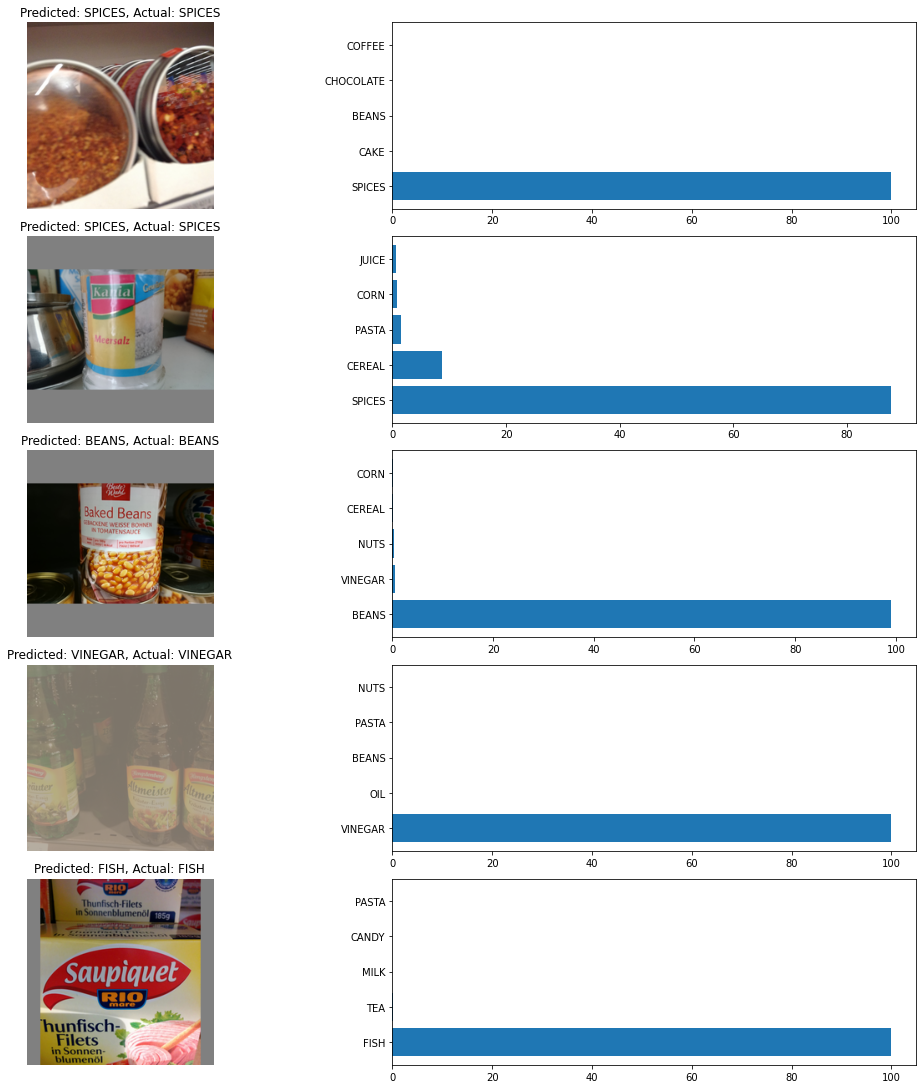

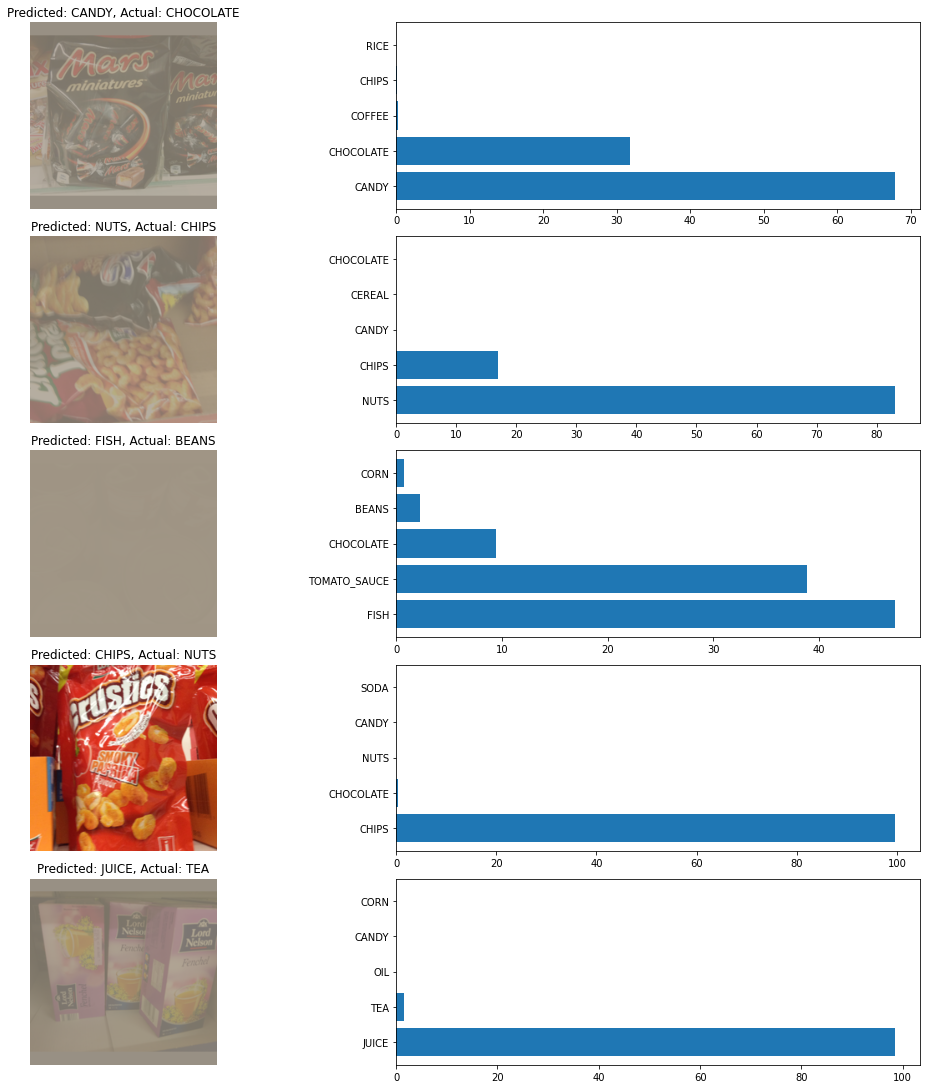

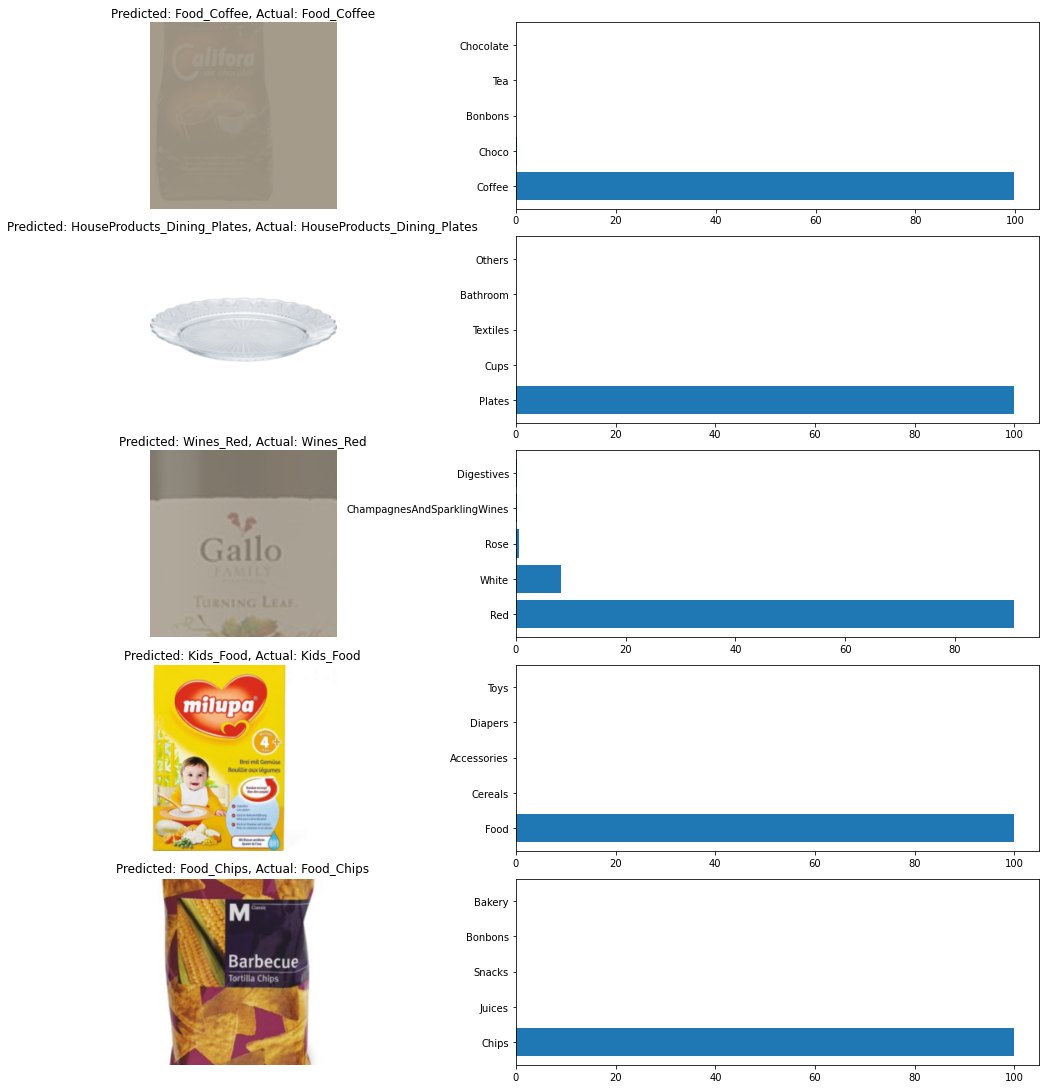

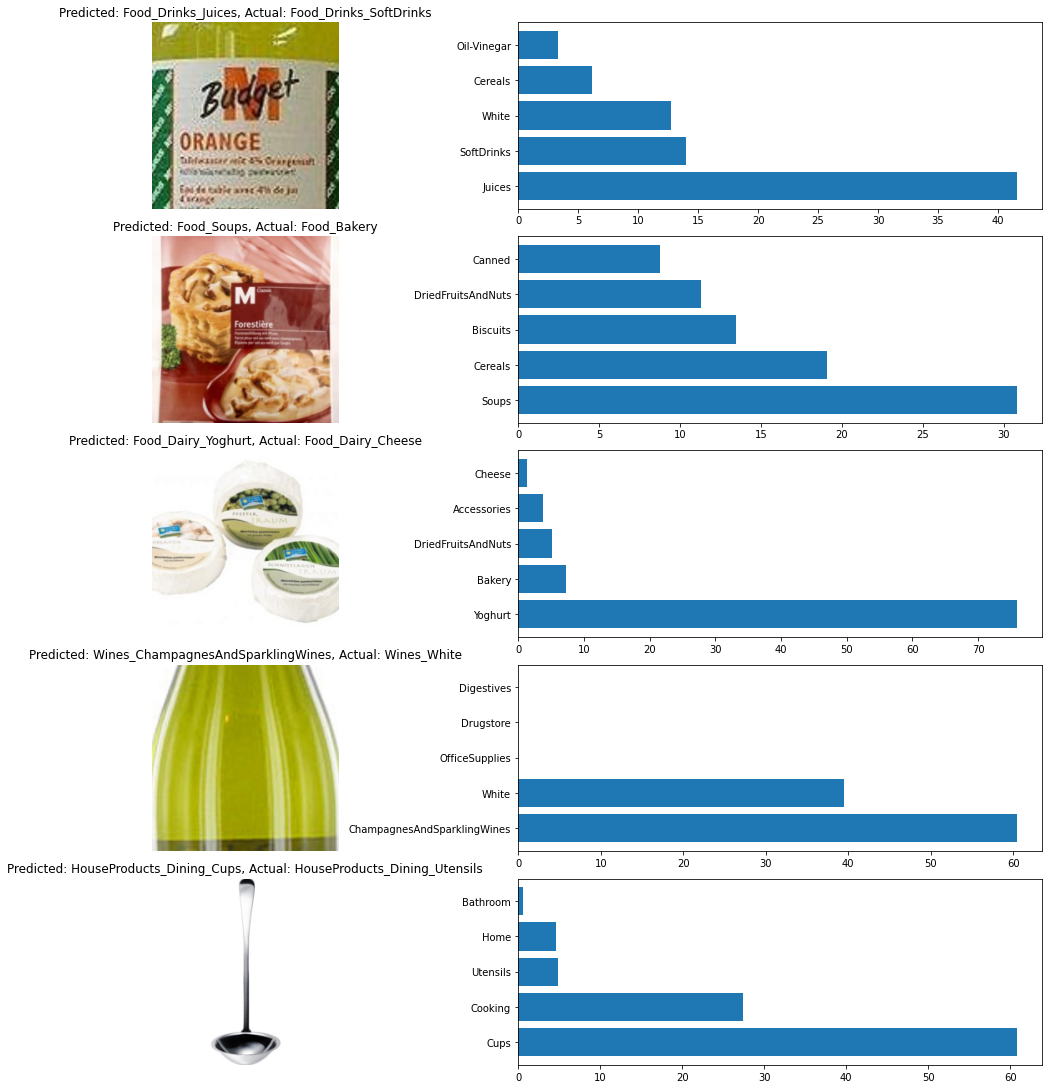

In [26]:
# Function for plotting some results
import random
random.seed(10)
img_net_mean = [0.485, 0.456, 0.406] # Use ImageNet mean
img_net_std = [0.229, 0.224, 0.225] # Use ImageNet Standard Dev

# Lookup for Freiburg
freiburg_lookup = train_frame_f[['label_encoded', 'label']].copy()
freiburg_lookup.drop_duplicates(inplace=True)
freiburg_lookup = dict(zip(freiburg_lookup['label_encoded'], 
                           freiburg_lookup['label']))

# Lookup for Grozi
grozi_lookup = train_frame_g[['label_encoded', 'label']].copy()
grozi_lookup.drop_duplicates(inplace=True)
grozi_lookup = dict(zip(grozi_lookup['label_encoded'], 
                       grozi_lookup['label']))


def plot_some_results(image_list, key_lookup, im_to_plot=5, file_name=None):
    random.shuffle(image_list) # Shuffle images
    plot_images = image_list[:5]
    
    # Plot
    plt.figure(figsize=(15,15), facecolor='white')
    p_id = 1
    for idx, (image, val, l_pred, l_correct) in enumerate(plot_images):
        
        plt.tight_layout()
        
        # Plot Image
        im_rev_tform = inverse_normalize(image, img_net_mean, img_net_std).cpu() # Untransform
        im_rev_tform = im_rev_tform.permute(1,2,0)
        l_pred_plot = key_lookup[l_pred.cpu().item()]
        l_correct_plot = key_lookup[l_correct.cpu().item()]
#         if 'Grozi' in file_name:
#             l_pred_plot = l_pred_plot[(l_pred_plot.rfind('_')+1):]
#             l_correct_plot = l_correct_plot[(l_correct_plot.rfind('_')+1):]

        plt.subplot(im_to_plot, 2, p_id)
        plt.imshow(im_rev_tform) # Plot images
        plt.title('Predicted: ' + l_pred_plot + ', Actual: ' + l_correct_plot)
        plt.axis('off') # Don't want axis for images
        p_id += 1
            
        # Plot Labels
        plt.subplot(im_to_plot, 2, p_id)
        val_classes = val[1].cpu()
        class_plot = [] # Convert from indices
        for lab in val_classes:
            v = key_lookup[lab.item()]
            if '_' in v and 'Grozi' in file_name: # Convert to cleaner label if needed
                v_f = v[(v.rfind('_')+1):]
                class_plot.append(v_f)
            else:
                class_plot.append(v)
        plt.barh(class_plot, val[0].cpu())
        p_id += 1
        
    # Save figure
    if file_name:
        plt.savefig(file_name)

plot_some_results(c_im_f, freiburg_lookup, file_name='Freiburg_Correct.png') # Freiburg Correct
plot_some_results(i_im_f, freiburg_lookup, file_name='Freiburg_Incorrect.png') # Freiburg Incorrect
plot_some_results(c_im_g, grozi_lookup, file_name='Grozi_Correct.png') # Grozi Correct
plot_some_results(i_im_g, grozi_lookup, file_name='Grozi_Incorrect.png') # Grozi Incorrect